In [1]:
from dataset import load_dataset_bitcoinotc, split_graph
from heuristics import *
from evaluation import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma 
import scipy as sp

In [2]:
sp.__version__

'1.9.3'

In [3]:
G, date_list = load_dataset_bitcoinotc()
edge_list = [(s,t) for s,t,a in G.edges(data=True) if a['rating'] > 0]
# G = G.edge_subgraph(edge_list)
G_train, G_test = split_graph(G, date_list, 0.5)

TIME SPLIT 1358384774.49232


In [4]:
node_list = list(G_train.nodes(data=True))
edge_list = list(G_train.edges(data=True))

(array([6.1200e+02, 8.0000e+00, 6.5000e+01, 5.9000e+01, 2.6900e+02,
        1.0503e+04, 4.3280e+03, 1.1480e+03, 2.2200e+02, 5.8200e+02]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <BarContainer object of 10 artists>)

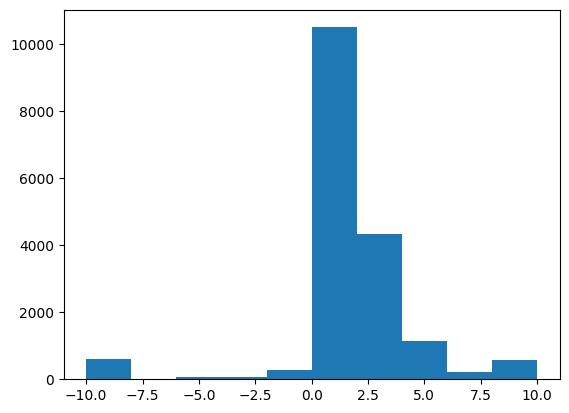

In [5]:
rating_list = [a['rating'] for u,v,a in edge_list]
plt.hist(rating_list)

In [47]:
(np.array(rating_list)<0).sum()/len(rating_list)

0.05692290402337604

In [ ]:
len(rating_list)

In [ ]:
sorted_nodes = np.array(sorted(G_train.nodes()))
scores = common_neighbors_vectorized(G_train, nodelist=sorted_nodes)
scores

/Users/ktian/Desktop/College/Semesters/222-project/heuristics.py:61: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(G, nodelist=nodelist)
/Users/ktian/opt/miniconda3/envs/222/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


array([[ 0, 18,  0, ...,  0,  0,  3],
       [18,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 3,  1,  0, ...,  0,  0,  0]])

In [35]:
np.min(scores)

-9223372036854775808

In [36]:
np.max(scores)

-9223372036854775808

In [ ]:
# argsort in descending order, obtain u and v endpoints of sorted edges 
sorted_scoring_edges_u, sorted_scoring_edges_v = np.unravel_index(np.argsort(-scores, axis=None), shape=scores.shape)
sorted_scoring_edges = zip(
    sorted_nodes[sorted_scoring_edges_u],
    sorted_nodes[sorted_scoring_edges_v]
)

In [ ]:
len(list(sorted_scoring_edges))

10201636

In [ ]:
test_adj_mat = nx.to_numpy_matrix(G_test.subgraph(sorted_nodes))
test_inv_adj_mat = np.logical_not(test_adj_mat).astype(int)

train_adj_mat = nx.to_numpy_matrix(G_train.subgraph(sorted_nodes))
train_inv_adj_mat = np.logical_not(train_adj_mat).astype(int)

In [ ]:
# new edges: in test but not in train
new_edges = np.logical_and(test_adj_mat, train_inv_adj_mat).astype(int)
non_edges = test_inv_adj_mat

In [ ]:
print("New edges", test_adj_mat.sum() - train_adj_mat.sum())
print("Non-edges", test_inv_adj_mat.sum())
new_edges.sum(), non_edges.sum()

New edges 2360.0
Non-edges 10182493


(2360, 10182493)

In [ ]:
# average score on new edges (positive class)
np.multiply(scores, new_edges).sum()/new_edges.sum()

0.1309322033898305

In [ ]:
masked_arr = ma.array(scores, mask=~new_edges)

In [ ]:
masked_arr.fill(np.nan)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=int64)

In [ ]:
nonzero_x, nonzero_y = np.nonzero(np.multiply(scores, new_edges))

In [ ]:
nonzero_x.shape

(0,)

In [ ]:
# average score on non edges (negative class)
np.multiply(scores, non_edges).sum()/non_edges.sum()

0.060960611512328074

In [ ]:
test_attr_mat = nx.attr_matrix(G_test.subgraph(sorted_nodes), 
                    edge_attr='rating', rc_order=sorted_nodes)

/var/folders/yy/2293ngdn0yx7jb_sgll52frh0000gn/T/ipykernel_41244/1597008554.py:1: FutureWarning: attr_matrix will return an numpy.ndarray instead of a numpy.matrix in NetworkX 3.0.
  test_attr_mat = nx.attr_matrix(G_test.subgraph(sorted_nodes),


In [ ]:
# average score on test edges 
np.multiply(scores, test_adj_mat).sum()/test_adj_mat.sum()

0.20649845896672414

In [ ]:
# average score on test non-edges 
np.multiply(scores, 1-test_adj_mat).sum()/(1-test_adj_mat).sum()

0.060960611512328074